In [1]:
# STEP 1: Install
!pip install deepface opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=f9a39af122afdbadb50150638827bef86db02df38adb5fe3f3ff4b311c455d73
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [2]:
# STEP 2: Upload Gambar
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]


Saving Screenshot 2025-06-17 175638.png to Screenshot 2025-06-17 175638.png


In [3]:
import cv2
import matplotlib.pyplot as plt
from deepface import DeepFace

# Read image
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)


25-06-18 05:26:26 - Directory /root/.deepface has been created
25-06-18 05:26:26 - Directory /root/.deepface/weights has been created


In [11]:
deep_results = DeepFace.analyze(
    img_path=img_path,
    actions=['age', 'gender', 'emotion'],
    detector_backend='mtcnn',  # optional if needed
    enforce_detection=False
)

deep_img = img_rgb.copy()
deep_boxes = []
descriptions = []

print("\n📋 DeepFace Detection Summary:\n")
for i, face in enumerate(deep_results):
    region = face["region"]
    x, y, w, h = region["x"], region["y"], region["w"], region["h"]

    age = round(face['age'])
    gender_dict = face['gender']
    gender_label = max(gender_dict, key=gender_dict.get)
    gender_conf = gender_dict[gender_label]
    emotion = face['dominant_emotion'].capitalize()

    print(f"{i+1}. Gender: {gender_label:<6}  Age: {age:<3}  Emotion: {emotion}")


    # Short label on image
    short_label = f"#{i+1}: {gender_label}, {age}"
    cv2.rectangle(deep_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(deep_img, short_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 0), 1)

    # Store full info
    descriptions.append(f"Face #{i+1} → Gender: {gender_label}, Age: {age}, Emotion: {emotion}")
    deep_boxes.append((x, y, w, h))




Action: emotion: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


📋 DeepFace Detection Summary:

1. Gender: Man     Age: 27   Emotion: Happy
2. Gender: Man     Age: 29   Emotion: Happy
3. Gender: Man     Age: 26   Emotion: Happy
4. Gender: Woman   Age: 29   Emotion: Happy
5. Gender: Woman   Age: 29   Emotion: Happy
6. Gender: Man     Age: 28   Emotion: Happy
7. Gender: Woman   Age: 33   Emotion: Happy
8. Gender: Woman   Age: 28   Emotion: Happy
9. Gender: Man     Age: 31   Emotion: Happy
10. Gender: Man     Age: 32   Emotion: Happy


In [6]:
# Load Haar models
face_cascade  = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade   = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')  # fallback if mcs not found

haar_img = img_rgb.copy()
haar_faces = face_cascade.detectMultiScale(gray, 1.3, 5)
haar_boxes = []

for (x, y, w, h) in haar_faces:
    cv2.rectangle(haar_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    haar_boxes.append((x, y, w, h))

    roi_gray = gray[y:y+h, x:x+w]
    roi_color = haar_img[y:y+h, x:x+w]

    # Eyes
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (255, 255, 0), 2)

    # Mouth
    mouth_roi_gray = roi_gray[int(h/2):, :]
    mouth_roi_color = roi_color[int(h/2):, :]
    mouths = mouth_cascade.detectMultiScale(mouth_roi_gray, 1.5, 11)
    for (mx, my, mw, mh) in mouths:
        cv2.rectangle(mouth_roi_color, (mx, my), (mx + mw, my + mh), (0, 0, 255), 2)
        break  # only first mouth


In [7]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    union = boxA[2]*boxA[3] + boxB[2]*boxB[3] - interArea
    return interArea / union if union > 0 else 0


In [13]:
threshold = 0.5
matched = 0

for hbox in haar_boxes:
    for dbox in deep_boxes:
        iou = compute_iou(hbox, dbox)
        if iou >= threshold:
            matched += 1
            break

precision = matched / len(haar_boxes) if haar_boxes else 0
recall = matched / len(deep_boxes) if deep_boxes else 0

print(f"\n📊 IoU Matching Results (Threshold={threshold}):")
print(f"✅ DeepFace Faces: {len(deep_boxes)}")
print(f"✅ Haar Faces    : {len(haar_boxes)}")
print(f"✅ Matches       : {matched}")
print(f"🎯 Precision     : {precision:.2f}")
print(f"🎯 Recall        : {recall:.2f}")



📊 IoU Matching Results (Threshold=0.5):
✅ DeepFace Faces: 10
✅ Haar Faces    : 9
✅ Matches       : 9
🎯 Precision     : 1.00
🎯 Recall        : 0.90


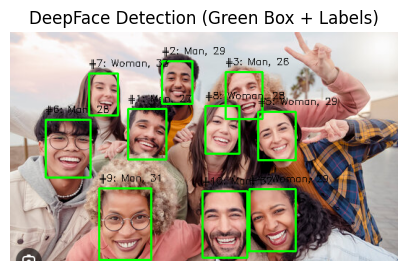


📋 DeepFace Detection Summary:

1. Gender: Man     Age: 27   Emotion: Happy
2. Gender: Man     Age: 29   Emotion: Happy
3. Gender: Man     Age: 26   Emotion: Happy
4. Gender: Woman   Age: 29   Emotion: Happy
5. Gender: Woman   Age: 29   Emotion: Happy
6. Gender: Man     Age: 28   Emotion: Happy
7. Gender: Woman   Age: 33   Emotion: Happy
8. Gender: Woman   Age: 28   Emotion: Happy
9. Gender: Man     Age: 31   Emotion: Happy
10. Gender: Man     Age: 32   Emotion: Happy


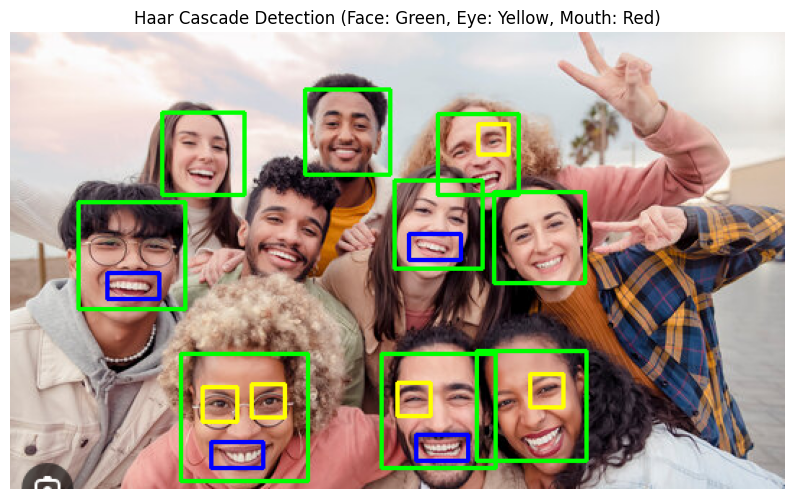

In [12]:
# DeepFace output
plt.figure(figsize=(5, 10))
plt.imshow(deep_img)
plt.title("DeepFace Detection (Green Box + Labels)")
plt.axis("off")
plt.show()
print("\n📋 DeepFace Detection Summary:\n")
for i, face in enumerate(deep_results):
    gender_dict = face['gender']
    gender_label = max(gender_dict, key=gender_dict.get)
    age = round(face['age'])
    emotion = face['dominant_emotion'].capitalize()

    print(f"{i+1}. Gender: {gender_label:<6}  Age: {age:<3}  Emotion: {emotion}")
# Haar output
plt.figure(figsize=(10, 6))
plt.imshow(haar_img)
plt.title("Haar Cascade Detection (Face: Green, Eye: Yellow, Mouth: Red)")
plt.axis("off")
plt.show()
